# Code for vacancy-induced Fano resonances

Each cell of this notebook works independently.

In [17]:
from math import pi, sqrt, tanh
import matplotlib
from matplotlib import pyplot as plt
import kwant
import numpy as np
from numpy import savetxt
import csv
import pandas as pd
import os
import seaborn as sns
import scipy.linalg as la

plt.rcParams.update({
    "text.usetex": True,
    "font.family":"sans-serif",
    "font.sans-serif": ["Helvetica"]
})

## Conductance
### Code for acgnr conductance with vacancies.

In order to store data from several lattices we generate several dictionaries whose keys are the systems, labelled from 0 to i:

* `d_acgsublat = {}`          dic. for sublatices of each lattice.
* `d_acsyst = {}`             dic. for systems.
* `d_acfin = {}`              dic. for terminated systems.
* `d_acsmatrix = {}`          dic. for scattering matrices.
* `d_acdata = {}`             dic. for conductance

For plotting whole energy specturm or another energy interval we use:

* Conductance separated by $2e²/h$ $\rightarrow$ `d_acdata[i].append(d_acsmatrix[i].transmission(0, 1)+i)`
* Conductance not separated $\rightarrow$ `d_acdata[i].append(d_acsmatrix[i].transmission(0, 1))`

For choosing energy interval:

* Whole range $\rightarrow$ `energies = np.linspace(-0.1,1,600)`
* Custom $\rightarrow$ `energies = np.linspace(-0.1,0.4,600)`

$N$ in graphs stands for the dimer in which the vacancy is located.

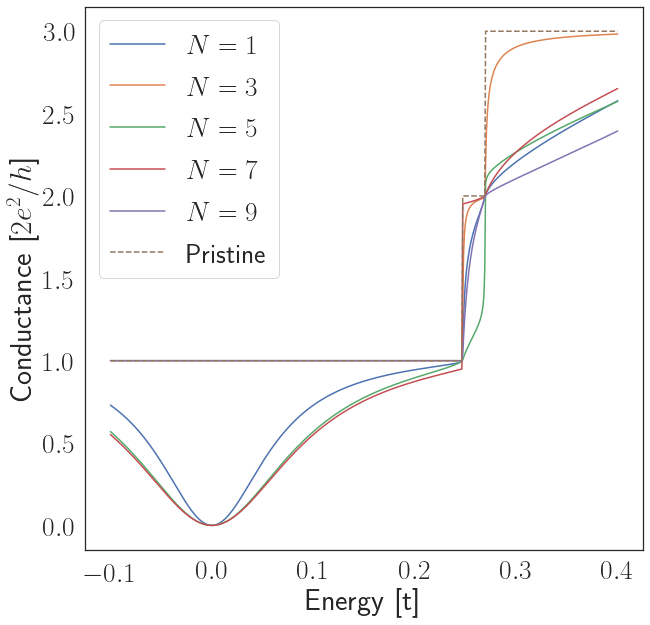

In [3]:
d_acgr= {}                # not in use
d_acgsublat = {}          
d_acsyst = {}             
d_acfin = {} 


## Generation of open systems:

for i in range(6):
  # lattice generation and sublattice labeling (here reads a,b)
  d_acgr[i] = kwant.lattice.general([(sqrt(3)/2, 1/2), (0,1)],[(-1/sqrt(12), -1/2), (1/sqrt(12),1/2)],norbs=1)
  a,b = d_acgr[i].sublattices
  # system generation with kwant.Builder() which is an object representing a tb system defined on a graph.
  # nodes of the graph are lattice sites. Values associated with nodes -> on-site hamiltonian, values associated
  # with edges -> hopping integrals.
  d_acsyst[i] = kwant.Builder()
  # setting system's geometry
  def make_system(l, w, pot = 0.1):
      def nrb(pos):
          (x,y) = pos
          return 0 <= x <= l and 0.5 <= y <=w
      def potential(site):   # setting on.site energy for each node in the graph.                
          (x,y) = site.pos
          return pot    
      d_acsyst[i][d_acgr[i].shape(nrb, (0, 0))] = potential
      # setting hopping integrals, .hoppingkind is a tuple pattering hoppings which we fill using .neighbors()
      hoppings = ()
      d_acsyst[i][d_acgr[i].neighbors()] = -1 # t = -1
      # we iterate over the lattices erasing one site in each but in d_acsyst[5] which is a pristine lattice.
      if i != 5:
        del d_acsyst[i][b(2,i-1)]
        
      ''' For double vacancies (abstract figure):
      if i ==1: # N=1 sB
        del d_acsyst[i][b(10,-5)]
      if i ==2: # N= 1 sA
        del d_acsyst[i][a(10,-4)]
      if i ==3: # N=7 sA
        del d_acsyst[i][a(10,-1)]
      if i == 4: #N=1 doble
        del d_acsyst[i][a(10,-4)]
        del d_acsyst[i][b(10,-5)]
      if i == 5: #N=11
        del d_acsyst[i][a(10,1)]
        del d_acsyst[i][b(10,0)] '''
    
      # we set the system's translational symmetry in the direction (-sqrt(3),0) and generate the leads with it.
      sym = kwant.TranslationalSymmetry((-sqrt(3),0))
      lead = kwant.Builder(sym)
      def lead_shape(pos):
          (x,y) = pos
          return 0.5 <= y <= w
      # setting on-site and hopping integrals in leads matching to lattice.
      lead[d_acgr[i].shape(lead_shape, (1,1))] = pot
      lead[d_acgr[i].neighbors()] = -1
      return d_acsyst[i], [lead, lead.reversed()]
      # Generating the system, attaching leads and finalizing it.
  d_acsyst[i], leads = make_system(l=20,w = 10, pot = 0)
  for lead in leads:
    d_acsyst[i].attach_lead(lead)
  d_acfin[i] = d_acsyst[i].finalized()


sns.set(font_scale=2.5)
sns.set_style("white")
# Labels for conductance curves.
labels = ['$N=1$','$N=3$','$N=5$','$N=7$','$N=9$','Pristine']

## Conductance representation:

d_acsmatrix = {}          
d_acdata = {}             
energies = np.linspace(-0.1,0.4,600)

for i in range(6):
  d_acdata[i] = []
  for energy in energies:
      # generating s matrix
      d_acsmatrix[i] = kwant.smatrix(d_acfin[i], energy)
      # getting transmission prob. from lead 0 to lead 1 (we are only using 2)
      d_acdata[i].append(d_acsmatrix[i].transmission(0, 1))
plt.figure(figsize = (10,10))

# plotting the curves in the same graph.
for i in range(6):  
  if i == 5:
    plt.plot(energies, d_acdata[i], '--', label = labels[i]) 
  else: 
    plt.plot(energies, d_acdata[i], label = labels[i])
plt.xlabel("Energy [t]")
plt.ylabel("Conductance [$2e^2/h$]")
plt.legend()
plt.show();

### Code for zzgnrs with vacancies.

For zzgnrs the routine is the same but we dont usually separate the conductance by $2e²/h$

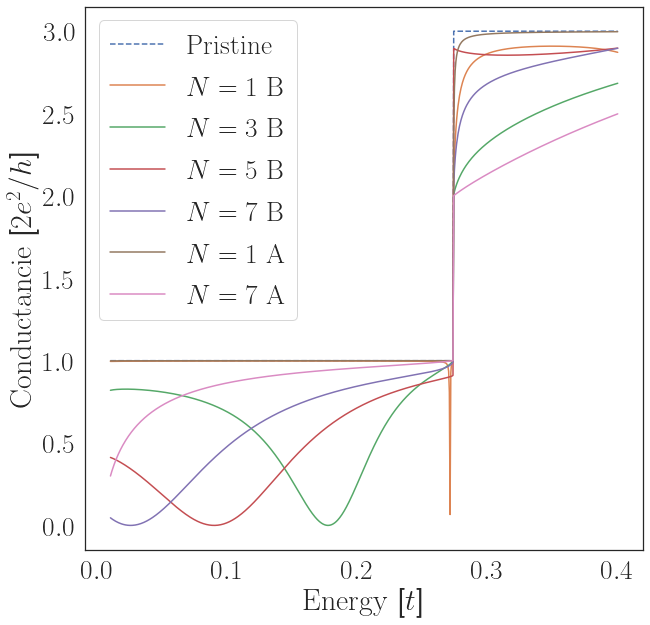

In [6]:
sns.set(font_scale=2.5)
sns.set_style("white")

## Generation of open systems:

d_gr= {}                
d_gsublat = {}          
d_syst = {}             
d_fin = {}              
for i in range(7):
  d_gr[i] = kwant.lattice.honeycomb(norbs=1)
  a,b = d_gr[i].sublattices
  d_syst[i] = kwant.Builder()
  def make_system(l, w, pot = 0.1):
      def nrb(pos):
          (x,y) = pos
          return 0 <= x <= l and 0.5 <= y <=w
      def potential(site):                        
          (x,y) = site.pos
          return pot    
      d_syst[i][d_gr[i].shape(nrb, (0, 0))] = potential 
      hoppings = ()
      d_syst[i][[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1
      d_syst[i][d_gr[i].neighbors()] = -1
    
      
      if i == 1:
        del d_syst[i][b(7,2*i-2)]
      if i ==2:
        del d_syst[i][b(7,2*i-2)]
      if i ==3:
        del d_syst[i][b(7,2*i-2)]
      if i ==4:
        del d_syst[i][b(7,2*i-2)]
      if i == 5:
        del d_syst[i][a(6,1)]
      if i == 6:
        del d_syst[i][a(6,7)]
     
      sym = kwant.TranslationalSymmetry((-1,0))      
      sym.add_site_family(a, other_vectors= [(-1,2)]) 
      sym.add_site_family(b, other_vectors= [(-1,2)]) 
      lead = kwant.Builder(sym)
      def lead_shape(pos):
          (x,y) = pos
          return 0.5 <= y <= w
      lead[d_gr[i].shape(lead_shape, (1,1))] = pot
      lead[d_gr[i].neighbors()] = -1
      return d_syst[i], [lead, lead.reversed()]
  d_syst[i], leads = make_system(l= 20,w = 14, pot = 0.006)
  for lead in leads:
    d_syst[i].attach_lead(lead)
  d_fin[i] = d_syst[i].finalized()

## Plotting conductance

labelo = ['Prístina','$N=1$ $\mathrm{B}$','$N=3$ $\mathrm{B}$','$N=5$ $\mathrm{B}$','$N=7$ $\mathrm{B}$','$N=1$ $\mathrm{A}$','$N=7$ $\mathrm{A}$']
d_smatrix = {}          
d_data = {}             
energies = np.linspace(0.01, 0.4,700)
for i in range(7):
  d_data[i] = []
  for energy in energies:
      d_smatrix[i] = kwant.smatrix(d_fin[i], energy)    
      d_data[i].append(d_smatrix[i].transmission(0, 1))
plt.figure(figsize = (10,10))
for i in range(7): 
    if i == 0:
        plt.plot(energies, d_data[i], '--', label = '$\mathrm{Pristine}$') 
    else: 
        plt.plot(energies, d_data[i], label =labelo[i])
plt.xlabel("Energy [$t$]")
plt.ylabel("Conductance [$2e^2/h$]")
plt.legend(loc=2)
plt.show();

## DOS and LDOS


Kwant uses KPM (https://kwant-project.org/doc/dev/reference/kwant.kpm) avoiding exact diagonalization of the tb Hamiltonian using chebyshev polynomials.

In this case, DOS is expressed as
$\rho(E) = \sum_{k=0}^{n-1}\delta(E-E_k) = \mathrm{Tr}(\delta(E-H))$, 
being $n$ the dimension of Hilbert space.

Global density of states is 
$\rho(E) = \mathrm{Tr}(\delta(E-H)) \approx \frac{1}{R} \sum_r \langle r| \delta(E-H)|r\rangle$,
being $r$ random vectors.

Local density of states is
$\rho(E)^i=\langle i| \delta(E-H)|i\rangle$
which is an exact expression.

### Acgnrs

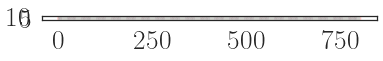

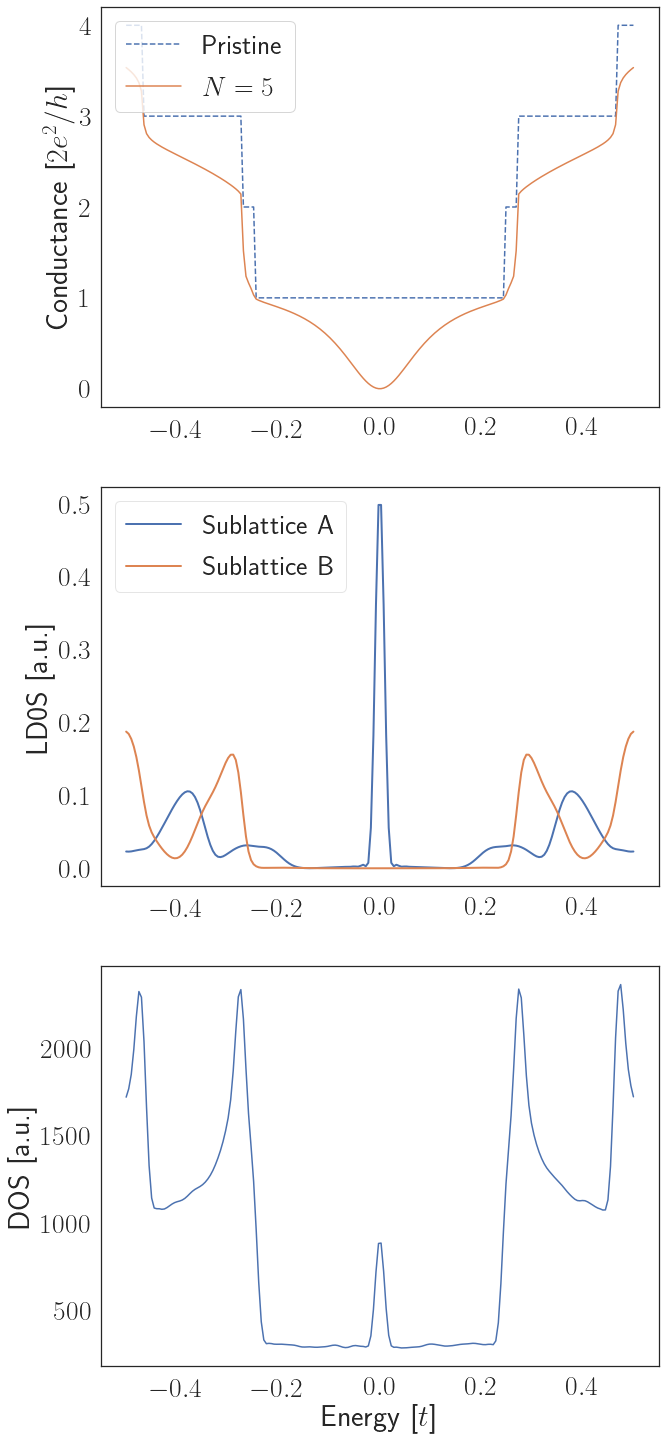

In [3]:
sns.set(font_scale=2.5)
sns.set_style("white")

## System generation

ac_energies = np.linspace(-0.5,0.5,200)
d_acgr= {}                
d_acgsublat = {}          
d_acsyst = {}             
d_acfin = {}             
for i in range(4):
  d_acgr[i] = kwant.lattice.general([(sqrt(3)/2, 1/2), (0,1)],[(-1/sqrt(12), -1/2), (1/sqrt(12),1/2)],norbs=1)
  a,b = d_acgr[i].sublattices
  d_acsyst[i] = kwant.Builder()
  def make_system(l, w, pot = 0.1):
      def nrb(pos):
          (x,y) = pos
          return 0 <= x <= l and 0.5 <= y <=w
      def potential(site):                        
          (x,y) = site.pos
          return pot    
      d_acsyst[i][d_acgr[i].shape(nrb, (0, 0))] = potential 
      hoppings = ()
      d_acsyst[i][[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1
      d_acsyst[i][d_acgr[i].neighbors()] = -1

      if i != 0:
        del d_acsyst[i][b(10,i-6)]
       
      sym = kwant.TranslationalSymmetry((-sqrt(3),0))
      lead = kwant.Builder(sym)
      def lead_shape(pos):
          (x,y) = pos
          return 0.5 <= y <= w
      lead[d_acgr[i].shape(lead_shape, (1,1))] = pot
      lead[d_acgr[i].neighbors()] = -1
      return d_acsyst[i], [lead, lead.reversed()]
  d_acsyst[i], leads = make_system(l=800, w = 10, pot = 0)
  for lead in leads:
    d_acsyst[i].attach_lead(lead)
  d_acfin[i] = d_acsyst[i].finalized()
        

## Conductance

acd_smatrix = {}          
acd_data = {} 
for i in range(4):
  acd_data[i] = []
  for energy in ac_energies:
      acd_smatrix[i] = kwant.smatrix(d_acfin[i], energy)    
      acd_data[i].append(acd_smatrix[i].transmission(0, 1))

labels = ['$N=1$','$N=2$','$N=5$']
'''for i in range(4): 
    if i == 0:
        plt.plot(ac_energies, acd_data[i], '--', label = 'Pristine') 
    else: 
        plt.plot(ac_energies, acd_data[i], label = labels[i-1])
plt.xlabel("Energy [$t$]")
plt.ylabel("Conductance [$2e^2/h$]")
plt.title('Conductance')
plt.legend(loc=2,prop={'size': 15})'''

## DOS
# We create two dictionaries for the spectrum and the densities 
ac_spectrum = {}
ac_densities = {}  

for i in range(4):
  ac_spectrum[i] = kwant.kpm.SpectralDensity(d_acfin[i], rng=0, num_vectors = 500)
  ac_spectrum[i].add_moments(1000)
  ac_densities[i] = ac_spectrum[i](ac_energies)

## Function for plotting everything together

ac_energies = np.linspace(-0.5,0.5,200)
def acplot_dos(labels_to_data,i):     # i stands for i-th nanoribbon.
    fig = plt.figure(figsize = (10,25))
    plt.subplot(3,1,1)
    plt.plot(ac_energies, acd_data[0], '--', label = 'Pristine') 
    plt.plot(ac_energies, acd_data[i], label ='$N=5$')
    plt.ylabel("Conductance [$2e^2/h$]")
    plt.legend(loc=2)
    plt.subplot(3,1,2)
    # label == sublattice, data == (x,y) position within the ribbon
    # we use it to select the unit cell in which we compute LDOS
    for label, (x, y) in labels_to_data:
        plt.plot(x, y.real, label=label, linewidth=2)
    plt.legend(loc=2, framealpha=0.5)
    plt.ylabel("LD0S [a.u.]")
    plt.subplot(3,1,3)
    plt.plot(ac_energies,ac_densities[i].real)
    plt.xlabel("Energy [$t$]")
    plt.ylabel("DOS [a.u.]")
    plt.show()
    plt.show()


## Plotting

sitio  = np.array([8,3])
# we need the tag of the unit cell in which we compute the LDOS, we make this by:
donde = lambda s: s.tag == sitio 
vectores = kwant.kpm.LocalVectors(d_acfin[3], donde)
aclocal_dos = kwant.kpm.SpectralDensity(d_acfin[3],num_vectors = None,
                                      vector_factory = vectores,
                                      mean = False, rng = 0)
aclocal_dos.add_moments(1000)
acloc_densities = aclocal_dos(ac_energies)


acplot_dos([('Sublattice A', (ac_energies,acloc_densities[:,0])),
          ('Sublattice B',(ac_energies,acloc_densities[:,1]))],3);

### Zzgnr

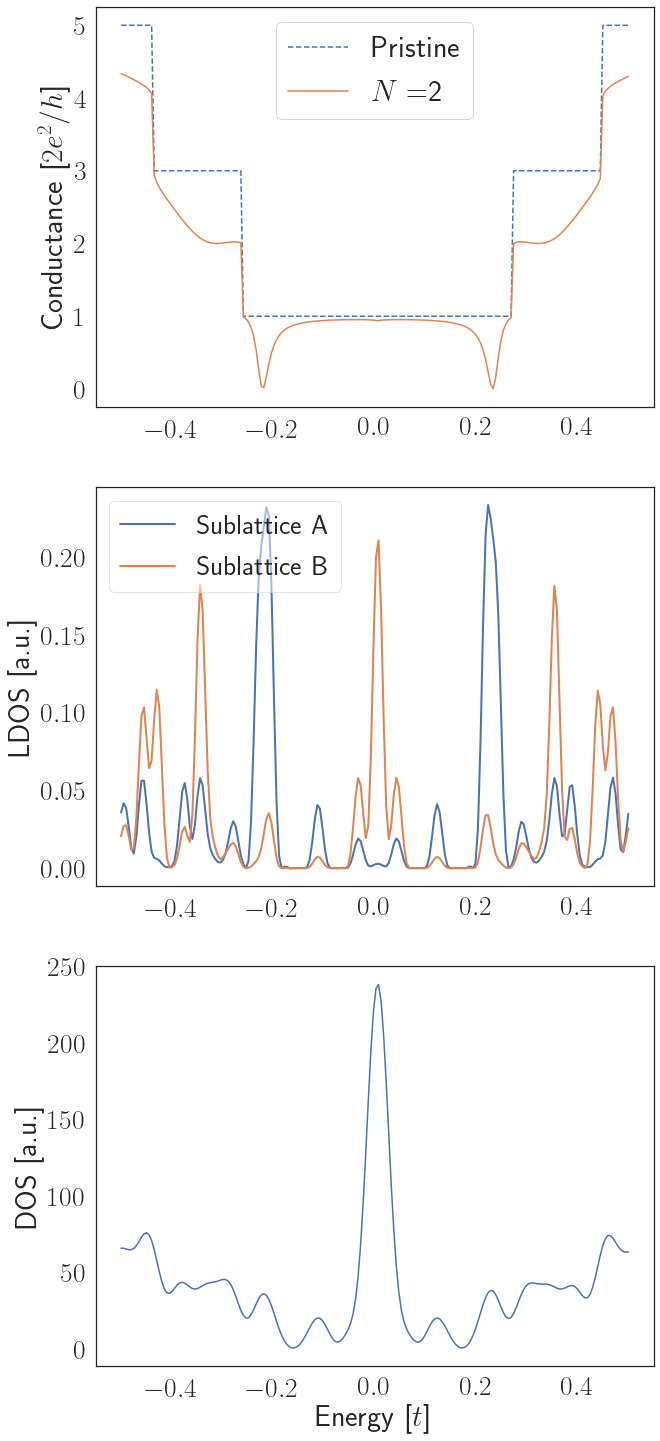

In [16]:
energies = np.linspace(-0.5,0.5,200)
sns.set(font_scale=2.5)
sns.set_style("white")

d_gr= {}               
d_gsublat = {}          
d_syst = {}             
d_fin = {}  

for i in range(6):
  d_gr[i] = kwant.lattice.honeycomb(norbs=1)
  a,b = d_gr[i].sublattices
  d_syst[i] = kwant.Builder()
  def make_system(l, w, pot = 0.1):
      def nrb(pos):
          (x,y) = pos
          return 0 <= x <= l and 0.5 <= y <=w
      def potential(site):                        
          (x,y) = site.pos
          return pot    
      d_syst[i][d_gr[i].shape(nrb, (0, 0))] = potential 
      hoppings = ()
      d_syst[i][[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1
      d_syst[i][d_gr[i].neighbors()] = -1
  
      if i != 0:
          del d_syst[i][b(2,i-1)]

      sym = kwant.TranslationalSymmetry((-1,0))      
      sym.add_site_family(a, other_vectors= [(-1,2)]) 
      sym.add_site_family(b, other_vectors= [(-1,2)]) 
      lead = kwant.Builder(sym)
      def lead_shape(pos):
          (x,y) = pos
          return 0.5 <= y <= w
      lead[d_gr[i].shape(lead_shape, (1,1))] = pot
      lead[d_gr[i].neighbors()] = -1
      return d_syst[i], [lead, lead.reversed()]
  d_syst[i], leads = make_system(l= 20,w = 14, pot = 0.006)
  for lead in leads:
    d_syst[i].attach_lead(lead)
  d_fin[i] = d_syst[i].finalized()

# Conductance & DOS

spectrum = {}
densities = {}    
d_smatrix = {}          
d_data = {} 

for i in range(6):
  d_data[i] = []
  for energy in energies:
      d_smatrix[i] = kwant.smatrix(d_fin[i], energy)    
      d_data[i].append(d_smatrix[i].transmission(0, 1))

for i in range(6):
  spectrum[i] = kwant.kpm.SpectralDensity(d_fin[i], rng=0, num_vectors = 500)
  spectrum[i].add_moments(400)
  densities[i] = spectrum[i](energies)
    
def plot_dos(labels_to_data,i):     
    plt.figure(figsize = (10,25))
    plt.subplot(3,1,1)
    plt.plot(energies, d_data[0], '--', label = 'Pristine') 
    plt.plot(energies, d_data[i], label ="$N=$"+str(i))
    plt.ylabel("Conductance [$2e^2/h$]")
    plt.legend(loc='upper center',prop={'size': 30})
    plt.subplot(3,1,2)
    for label, (x, y) in labels_to_data:
        plt.plot(x, y.real, label=label, linewidth=2)
    plt.legend(loc=2, framealpha=0.5)
    plt.ylabel("LDOS [a.u.]")
    plt.subplot(3,1,3)
    plt.plot(energies,densities[i].real,label = "$N=$"+str(i))
    plt.xlabel("Energy [$t$]")
    plt.ylabel("DOS [a.u.]")
    plt.show()
    
sitio  = np.array([3,2])
donde = lambda s: s.tag == sitio
vectores = kwant.kpm.LocalVectors(d_fin[2], donde)
local_dos = kwant.kpm.SpectralDensity(d_fin[2],num_vectors = None,
                                      vector_factory = vectores,
                                      mean = False, rng = 0)
local_dos.add_moments(1000)
loc_densities = local_dos(energies)

plot_dos([('Sublattice A', (energies,loc_densities[:,0])),
          ('Sublattice B',(energies,loc_densities[:,1]))],2);

## Bandstructure 
### Acgnr
DOS & Bandstructure

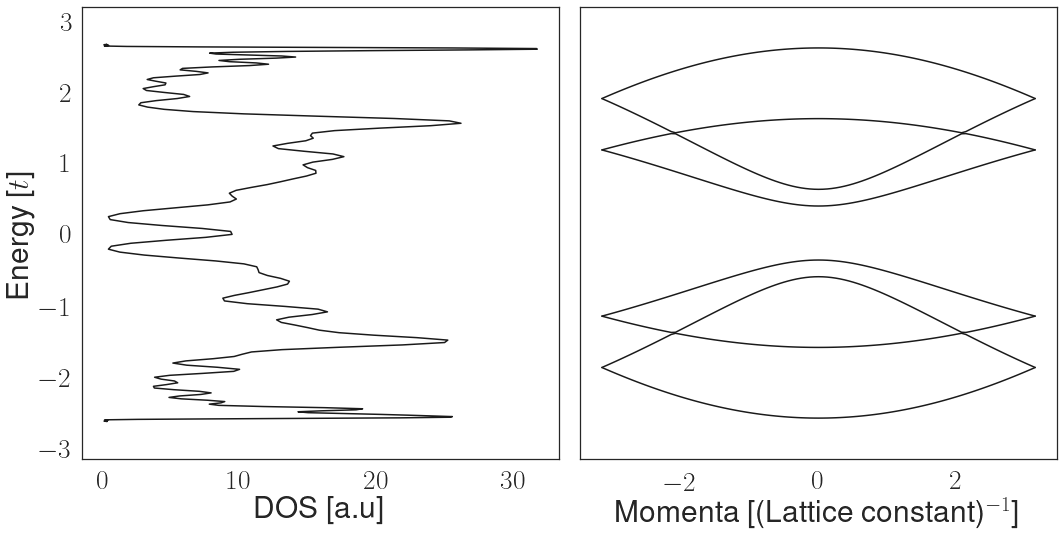

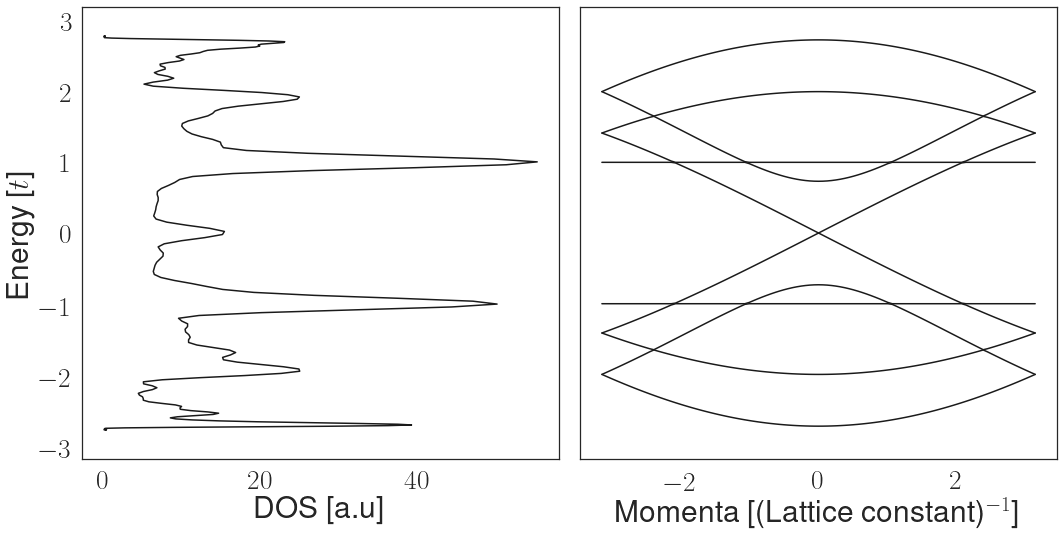

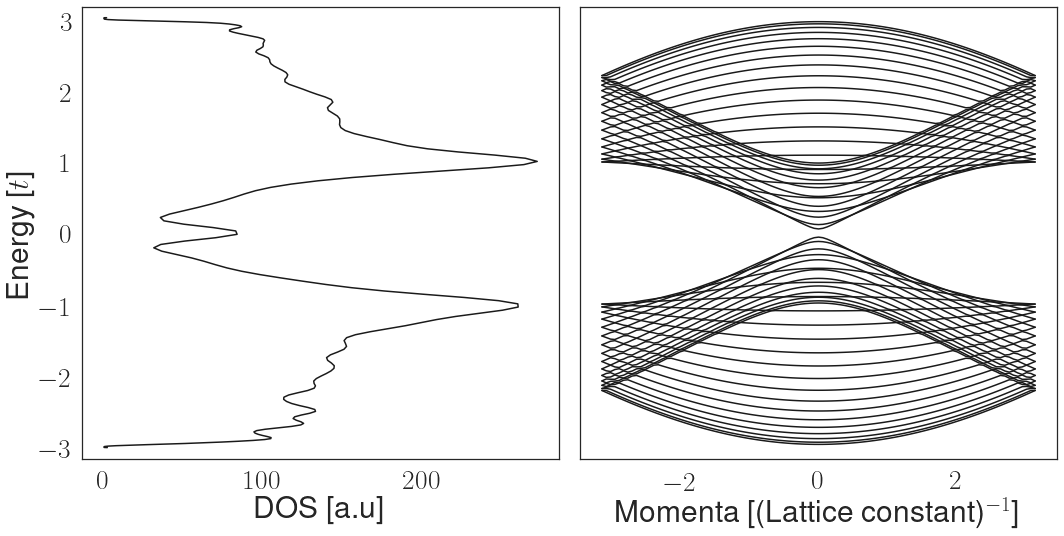

In [24]:
## System generation routine
ac_gr= {}
ac_gsublat = {}
ac_syst = {}
ac_fin = {}
L = [10,12,20]
W = [2,2.5,15]
for i in range(3):
  ac_gr[i] = kwant.lattice.general([(sqrt(3)/2, 1/2), (0,1)],[(-1/sqrt(12), -1/2), (1/sqrt(12),1/2)],norbs=1)
  a,b = ac_gr[i].sublattices
  ac_syst[i] = kwant.Builder()
  def make_system(l, w, pot = 0.1):
      def nrb(pos):
          (x,y) = pos
          return 0 <= x <= l and 0.5 <= y <=w
      def potential(site):                        
          (x,y) = site.pos
          return pot    
      ac_syst[i][ac_gr[i].shape(nrb, (0, 0))] = potential 
      hoppings = ()
      ac_syst[i][[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1
      ac_syst[i][ac_gr[i].neighbors()] = -1
      sym = kwant.TranslationalSymmetry((-sqrt(3),0)) 
      lead = kwant.Builder(sym)
      def lead_shape(pos):
          (x,y) = pos
          return 0.5 <= y <= w
      lead[ac_gr[i].shape(lead_shape, (1,1))] = pot
      lead[ac_gr[i].neighbors()] = -1
      return ac_syst[i], [lead, lead.reversed()]
  ac_syst[i], leads = make_system(L[i],W[i], pot = 0)
  for lead in leads:
    ac_syst[i].attach_lead(lead)
  ac_fin[i] = ac_syst[i].finalized()
  # Plotting the systems:
  #kwant.plot(ac_fin[i])


## Bandstructure

momenta = [-pi + 0.02 * pi * i for i in range(101)]
ac_spectrum = {}

for i in range(3):
  figac = plt.figure(figsize=(15,7.5))
  plt.subplot(1,2,1)
  ac_spectrum[i] = kwant.kpm.SpectralDensity(ac_fin[i], rng=0)
  energies, acdensities = ac_spectrum[i]()
  plt.plot(acdensities.real, energies,'k')
  plt.ylim(top =3.2)
  plt.ylim(bottom = -3.2)
  plt.xlabel("DOS [a.u]")
  plt.ylabel("Energy [$t$]")
  fig2 = plt.subplot(1,2,2)
  fig2.set(yticklabels=[])
# We simply use kwant's .Bands() at left lead.
  bands = kwant.physics.Bands(ac_fin[i].leads[0])
  energies = [bands(k) for k in momenta]
  plt.plot(momenta, energies,'k')
  plt.ylim(top =3.2)
  plt.ylim(bottom = -3.2)
  plt.xlabel("Momenta [(Lattice constant)$^{-1}$]")
  figac.tight_layout(pad=0.3)
  plt.show()

### Zzgnr
DOS & bandstructure

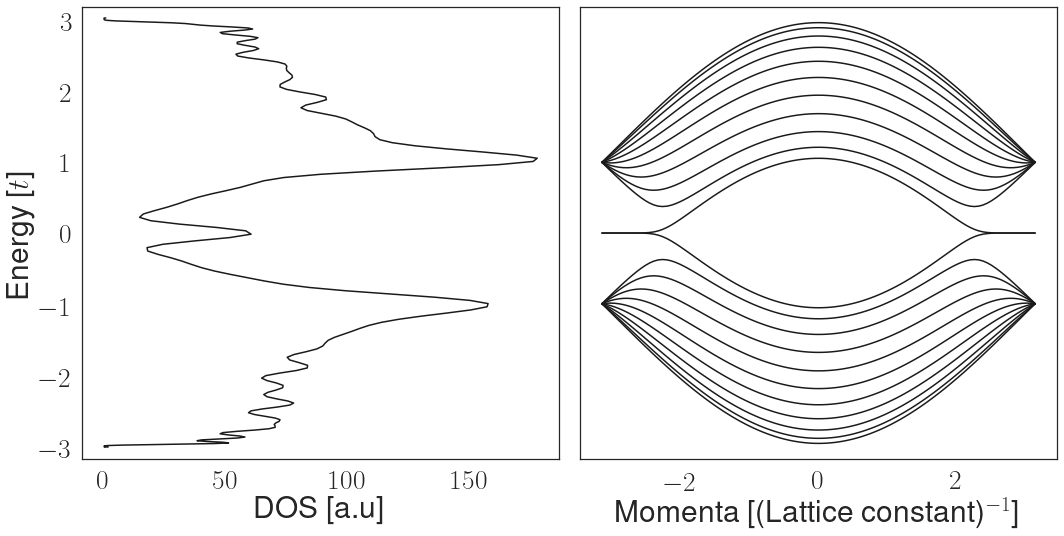

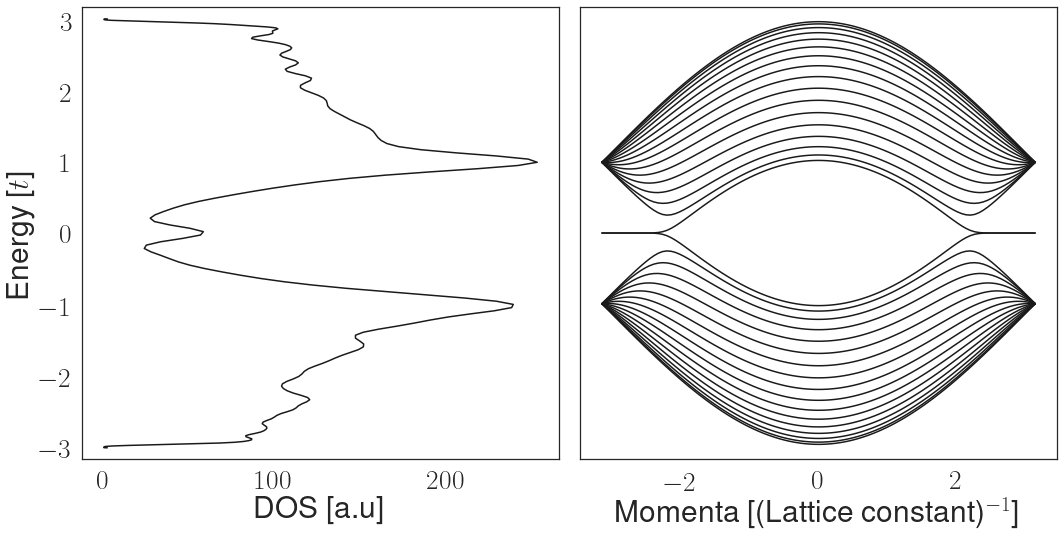

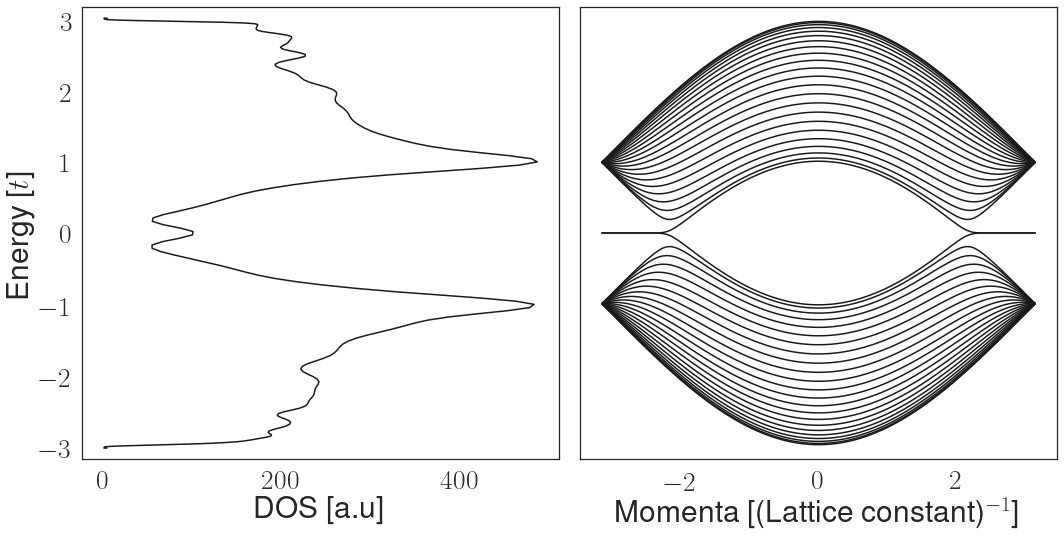

In [26]:
## System generation routine
zz_gr= {}
zz_gsublat = {}
zz_syst = {}
zz_fin = {}
L = [20,20,30]
W = [10,15,20]
for i in range(3):
  zz_gr[i] = kwant.lattice.honeycomb(norbs=1)
  a,b = zz_gr[i].sublattices
  zz_syst[i] = kwant.Builder()
  def make_system(l, w, pot = 0.1):
      def nrb(pos):
          (x,y) = pos
          return 0 <= x <= l and 0.5 <= y <=w
      def potential(site):                        
          (x,y) = site.pos
          return pot    
      zz_syst[i][zz_gr[i].shape(nrb, (0, 0))] = potential 
      hoppings = ()
      zz_syst[i][[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1
      zz_syst[i][zz_gr[i].neighbors()] = -1
      sym = kwant.TranslationalSymmetry((-1,0))      
      sym.add_site_family(a, other_vectors= [(-1,2)]) 
      sym.add_site_family(b, other_vectors= [(-1,2)]) 
      lead = kwant.Builder(sym)
      def lead_shape(pos):
          (x,y) = pos
          return 0.5 <= y <= w
      lead[zz_gr[i].shape(lead_shape, (1,1))] = pot
      lead[zz_gr[i].neighbors()] = -1
      return zz_syst[i], [lead, lead.reversed()]
  zz_syst[i], leads = make_system(L[i],W[i], pot = 0)
  for lead in leads:
    zz_syst[i].attach_lead(lead)
  zz_fin[i] = zz_syst[i].finalized()
  #kwant.plot(zz_fin[i])


momenta = [-pi + 0.02 * pi * i for i in range(101)]
d_spectrum = {}                              
 
for i in range(3):
  figzz = plt.figure(figsize=(15,7.5))
  plt.subplot(1,2,1)
  d_spectrum[i] = kwant.kpm.SpectralDensity(zz_fin[i], rng=100)
  energies, densities = d_spectrum[i]()
  plt.plot(densities.real, energies,'k')
  plt.ylim(top =3.2)
  plt.ylim(bottom = -3.2)
  plt.xlabel("DOS [a.u]")
  plt.ylabel("Energy [$t$]")
  fig2 = plt.subplot(1,2,2)
  fig2.set(yticklabels=[])
  bands = kwant.physics.Bands(zz_fin[i].leads[0])
  energies = [bands(k) for k in momenta]
  plt.plot(momenta, energies,'k')
  plt.ylim(top =3.2)
  plt.ylim(bottom = -3.2)
  plt.xlabel("Momenta [(Lattice constant)$^{-1}$]")
  figzz.tight_layout(pad=0.3)
  plt.show()

## Misc
### Getting system's sites as a list and conductance as a .csv

In [34]:
# System generation
graphene = kwant.lattice.honeycomb(norbs=1)
a0, b0 = graphene.sublattices
syst0= kwant.Builder()
def make_system0(l = 10, w = 10, pot = 0.1):
    def nrb(pos):
        (x,y) = pos
        return 0 <= x <= l and 0.5 <= y <=w
    def potential(site):                        
        (x,y) = site.pos
        return pot    
    syst0[graphene0.shape(nrb, (0, 0))] = potential 
    hoppings = ()
    syst0[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings]] = -1
    syst0[graphene.neighbors()] = -1
    sym0 = kwant.TranslationalSymmetry((-1,0))      
    sym0.add_site_family(a0, other_vectors= [(-1,2)]) 
    sym0.add_site_family(b0, other_vectors= [(-1,2)]) 
    lead = kwant.Builder(sym0)
    def lead_shape(pos):
        (x,y) = pos
        return 0.5 <= y <= w
    lead[graphene0.shape(lead_shape, (1,1))] = pot
    lead[graphene0.neighbors()] = -1
    return syst0, [lead, lead.reversed()]
syst0, leads = make_system0(l=10,w = 6.5, pot = 0.1)

# List of sites generation

nods_list = list(syst0.sites())    
df = pd.DataFrame(nods_list)
df.columns = ['Lattice', 'site']
df = df.astype({"Lattice": str})
dfb0 = df.loc[df['Lattice'] == '<Monatomic lattice 1 with 1 orbitals>']
b0_site = dfb0.iloc[:,1:].values
dfa0 = df.loc[df['Lattice'] == '<Monatomic lattice 0 with 1 orbitals>']
a0_site = dfa0.iloc[:,1:].values
a0_list = []
b0_list = []
for i in range (0,len(a0_site)): a0_list.append(tuple(a0_site[i][0]))
for i in range (0,len(b0_site)): b0_list.append(tuple(b0_site[i][0]))
    
def getKey(item):
    return item[0]

a_sort = sorted(a0_list, key=getKey)
b_sort = sorted(b0_list, key=getKey)
print("Sublattice A: \n")
print(a_sort)
print("\nSublattice B: \n")
print(b_sort)

# Saving conductance data in csv

data0 = []
for energy in energies:
        smatrix0 = kwant.smatrix(syst0, energy)
        data0.append(smatrix0.transmission(0,1))


Sublattice A: 

[(-3, 6), (-3, 7), (-2, 4), (-2, 5), (-2, 6), (-2, 7), (-1, 2), (-1, 3), (-1, 4), (-1, 5), (-1, 6), (-1, 7), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8, 1), (8, 2), (8, 3), (8, 4), (9, 1), (9, 2)]

Sublattice B: 

[(-3, 6), (-2, 4), (-2, 5), (-2, 6), (-1, 2), (-1, 3), (-1, 4), (-1, 5), (-1, 6), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 0), 